In [1]:
!pip install simpy

In [2]:
# Input parameter bounds
ARRIVAL_RATE_RANGE = (1, 10)      # customers per unit time
SERVICE_RATE_RANGE = (2, 15)      # customers served per unit time
NUM_SERVERS_RANGE = (1, 5)

SIM_TIME = 50     # simulation time per run
N_SIMULATIONS = 1000

In [3]:
import simpy
import random
import numpy as np

def queue_simulation(arrival_rate, service_rate, num_servers):
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=num_servers)

    wait_times = []

    def customer(env):
        arrival_time = env.now
        with server.request() as request:
            yield request
            wait_times.append(env.now - arrival_time)
            service_time = random.expovariate(service_rate)
            yield env.timeout(service_time)

    def arrival_process(env):
        while True:
            yield env.timeout(random.expovariate(arrival_rate))
            env.process(customer(env))

    env.process(arrival_process(env))
    env.run(until=SIM_TIME)

    return np.mean(wait_times) if wait_times else 0.0

In [4]:

import pandas as pd

data = []

for i in range(N_SIMULATIONS):
    arrival_rate = random.uniform(*ARRIVAL_RATE_RANGE)
    service_rate = random.uniform(*SERVICE_RATE_RANGE)
    num_servers = random.randint(*NUM_SERVERS_RANGE)

    avg_wait = queue_simulation(arrival_rate, service_rate, num_servers)

    data.append([
        arrival_rate,
        service_rate,
        num_servers,
        avg_wait
    ])

df = pd.DataFrame(
    data,
    columns=["arrival_rate", "service_rate", "num_servers", "avg_wait_time"]
)

df.head()

,arrival_rate,service_rate,num_servers,avg_wait_time
0,8.250958,6.492122,2,0.171131
1,1.029892,8.382440,3,0.000000
2,8.816297,5.075510,2,1.442509
3,3.062936,4.072236,2,0.016470
4,5.168149,11.416302,4,0.000047


In [5]:
df.to_csv("simpy_simulation_dataset.csv", index=False)

In [6]:

from sklearn.model_selection import train_test_split

X = df.drop("avg_wait_time", axis=1)
y = df["avg_wait_time"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=300, learning_rate=0.05, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=300, learning_rate=0.05, verbose=0)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    results.append({
        "Model": name,
        "RMSE": np.sqrt(mean_squared_error(y_val, preds)),
        "MAE": mean_absolute_error(y_val, preds),
        "R2": r2_score(y_val, preds)
    })

results_df = pd.DataFrame(results).sort_values("RMSE")
results_df

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 516
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 3
[LightGBM] [Info] Start training from score 0.782687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

,Model,RMSE,MAE,R2
5,CatBoost,0.390350,0.147434,0.955907
1,Random Forest,0.576056,0.160093,0.903974
4,LightGBM,0.605700,0.240285,0.893837
2,Gradient Boosting,0.671921,0.274627,0.869354
3,XGBoost,0.682535,0.180971,0.865194
0,Linear Regression,1.771175,1.269294,0.092217


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 516
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 3
[LightGBM] [Info] Start training from score 0.782687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

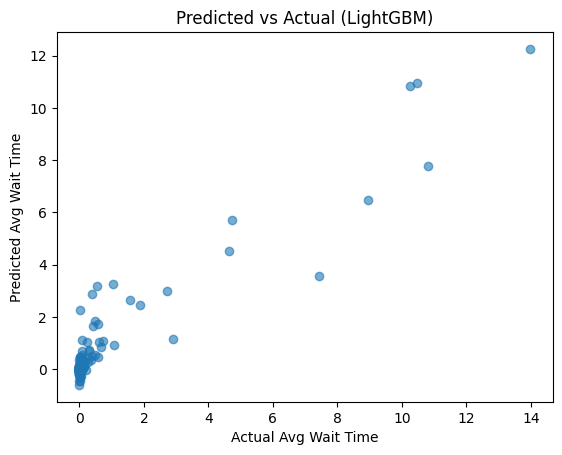

In [9]:
import matplotlib.pyplot as plt

best_model = LGBMRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
best_model.fit(X_train, y_train)
preds = best_model.predict(X_val)

plt.scatter(y_val, preds, alpha=0.6)
plt.xlabel("Actual Avg Wait Time")
plt.ylabel("Predicted Avg Wait Time")
plt.title("Predicted vs Actual (LightGBM)")
plt.show()